## 1. Read data from Database

In [3]:
import pandas as pd
import sqlite3

path = "/Users/pavel/PycharmProjects/stock-market-app/src/financial_data.db"

sqlFinancials  = """select *
from balance_sheet bs
left join pnl p
on bs.ticker = p.ticker
and bs.type = p.type
and bs.fiscalDateEnding = p.fiscalDateEnding
left join cash_flow cf
on bs.ticker = cf.ticker
and bs.type = cf.type
and bs.fiscalDateEnding = cf.fiscalDateEnding
"""
conn = sqlite3.connect(path)
financials_db = pd.read_sql(sqlFinancials, conn)
conn.close()

financials_db = financials_db.loc[:, ~financials_db.columns.duplicated()]

sqlCandles = "select * from candles"
conn = sqlite3.connect(path)
candles_db = pd.read_sql(sqlCandles, conn)
conn.close()

ModuleNotFoundError: No module named 'pandas'

In [ ]:
#for column in financials_db.columns:
#  print(column)

## 2. Counting 90-day average values

In [ ]:
candles = candles_db[['date_time','ticker', 'close']].copy()
candles = candles.sort_values(['ticker', 'date_time'])
candles['avg_90d'] = candles.groupby('ticker')['close'].rolling(90).mean().reset_index(0, drop=True)
candles

,date_time,ticker,close,avg_90d
92823,1999-11-01 00:00:00,AAPL,77.62,NaN
92822,1999-11-02 00:00:00,AAPL,80.25,NaN
92821,1999-11-03 00:00:00,AAPL,81.50,NaN
92820,1999-11-04 00:00:00,AAPL,83.62,NaN
92819,1999-11-05 00:00:00,AAPL,88.31,NaN
...,...,...,...,...
4,2024-06-24 00:00:00,XOM,114.05,113.702778
3,2024-06-25 00:00:00,XOM,114.37,113.853111
2,2024-06-26 00:00:00,XOM,114.41,113.971778
1,2024-06-27 00:00:00,XOM,114.90,114.095889


## 3. Merge financials and average prices

In [ ]:
candles['date_time'] = pd.to_datetime(candles['date_time'])

financials_db['fiscalDateEnding'] = pd.to_datetime(financials_db['fiscalDateEnding'])

candles = candles.sort_values(by='date_time')
financials_db = financials_db.sort_values(by='fiscalDateEnding')

financials = pd.merge_asof(
    financials_db,
    candles,
    left_on='fiscalDateEnding',
    right_on='date_time',
    by='ticker',
    direction='nearest'  # use nearest valus
)

## 4. Input parameters for analysis: tickers, period, financial indicators

In [ ]:
selected_ticker = 'ORCL'
start_date = '2019-01-01'
end_date = '2024-12-31'

## 5. Functions:
- graph indicator and average stock price
- heatmap for tickers

In [ ]:
import matplotlib.pyplot as plt

def drawIndicatorPricePlot(financial_data, selected_ticker, financial_indicator,
                           start_date, end_date):
  ticker_data = financial_data[(financial_data['ticker'] == selected_ticker) &
                         (financial_data['type'] == 'quarterly') &
                          (financial_data['fiscalDateEnding'] >= start_date) &
                          (financial_data['fiscalDateEnding'] <= end_date)]

  fig, ax1 = plt.subplots(figsize=(12, 6))

  ax1.bar(ticker_data['fiscalDateEnding'], ticker_data[financial_indicator], color='b',
        width=30, alpha=0.5)
  ax1.set_xlabel('Date')
  ax1.set_ylabel(financial_indicator, color='b')
  ax1.tick_params('y', colors='b')

  ax2 = ax1.twinx()
  ax2.plot(ticker_data['fiscalDateEnding'], ticker_data['avg_90d'], color='r')
  ax2.set_ylabel('avg_90d', color='r')
  ax2.tick_params('y', colors='r')

  plt.title(f"{financial_indicator} and avg_90d for Ticker: {selected_ticker}")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [ ]:
import seaborn as sns

def drawHeatMap(fin_data, financial_indicator, start_date, end_date):
  fin_data['fiscalDateEnding'] = pd.to_datetime(fin_data['fiscalDateEnding'])

  filtered_financials = fin_data[(fin_data['fiscalDateEnding'] >= start_date) &
                                  (fin_data['fiscalDateEnding'] <= end_date)]

  correlation_data = []

  unique_tickers = filtered_financials['ticker'].unique()

  for ticker in unique_tickers:
    ticker_data = filtered_financials[(filtered_financials['ticker'] == ticker) &
                                       (filtered_financials['type'] == 'quarterly')]
    if not ticker_data.empty:
        correlation = ticker_data[[financial_indicator, 'avg_90d']].corr().iloc[0, 1]
        correlation_data.append({'ticker': ticker, 'correlation': correlation})

  correlation_data = pd.DataFrame(correlation_data)

  correlation_data = correlation_data.sort_values(by='correlation', ascending=False)

  correlation_matrix = correlation_data.set_index('ticker')

  plt.figure(figsize=(12, 8))
  sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
  plt.title('Correlation between ' + financial_indicator + 'and avg_90d for all tickers')
  plt.show()

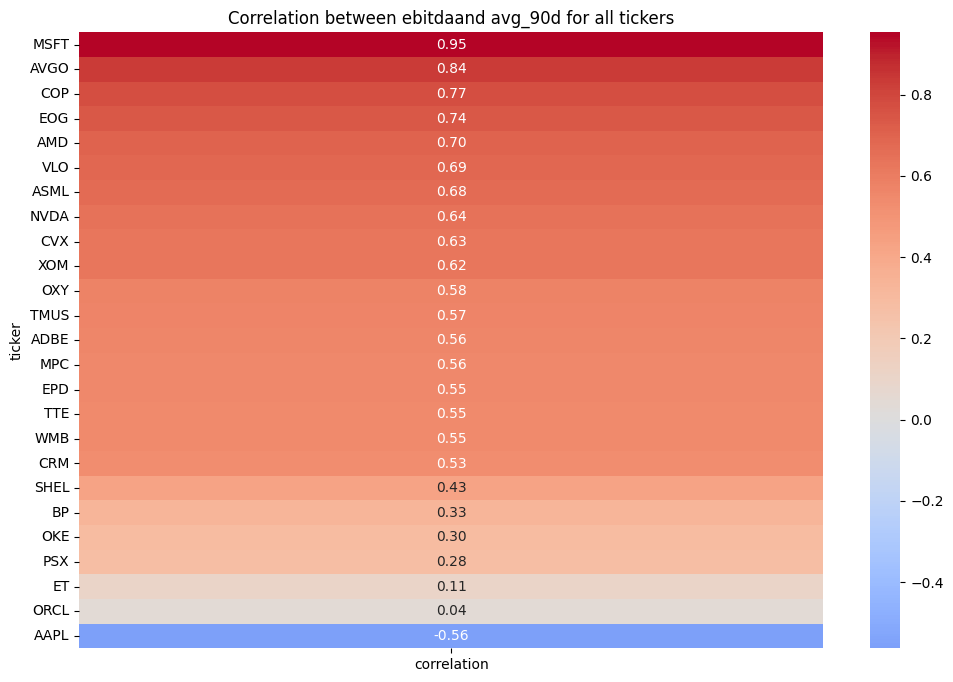

In [ ]:
drawHeatMap(financials, 'ebitda', start_date, end_date)

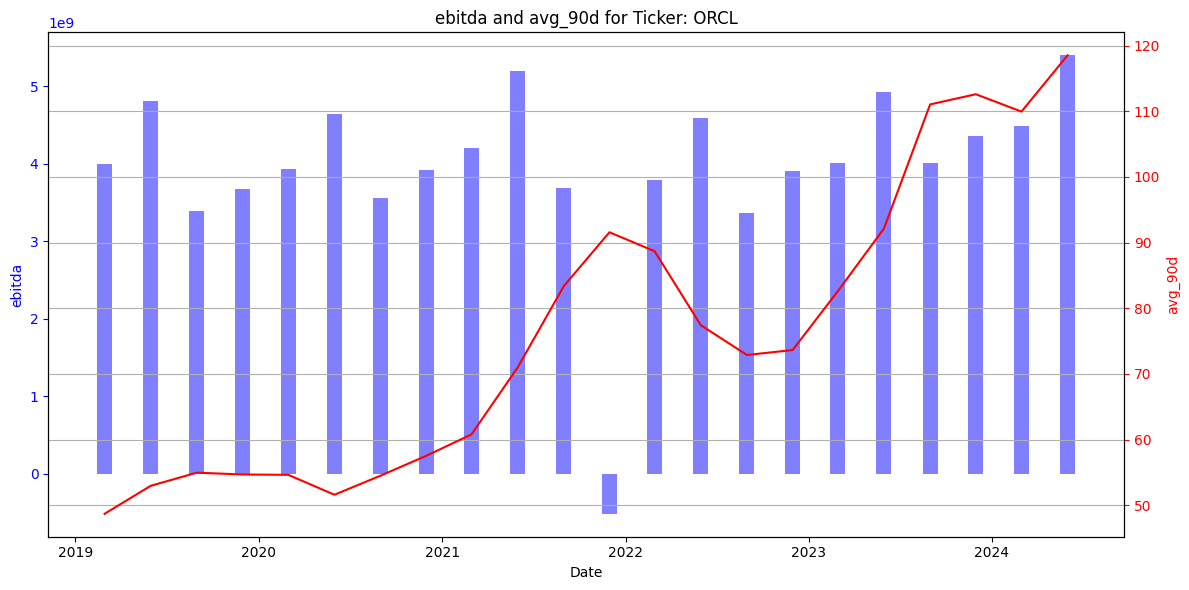

In [ ]:
drawIndicatorPricePlot(financials, selected_ticker, 'ebitda', start_date, end_date)